## Import e Configs

In [2]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.7 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=8f1c44caf45bd284596cb16dff37ce98507c1ce5080188df3f678e632e5d6858
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [3]:
import re
import os
from nltk.stem.porter import PorterStemmer
import emoji
import spacy
import string
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
%matplotlib inline

# Webscraping

criando função para fazer dataset de texto a partir de 3 editorias determinadas no site.

In [4]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [5]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,Experience 'Mobile Dhamaka' this Amazon Great ...,With the Amazon Great Indian Festival around t...,technology
1,Mark Zuckerberg shares pic with wife to announ...,Facebook Co-founder and Meta CEO Mark Zuckerbe...,technology
2,Will release a fix: Apple after users complain...,After some users complained of camera shaking ...,technology
3,Wipro fires 300 employees found 'Moonlighting'...,Wipro terminated the services of 300 employees...,technology
4,Idiot and liar: Musk to US professor who claim...,The world's richest man Elon Musk on Wednesday...,technology
5,Google CEO Sundar Pichai visits Indian Embassy...,Google CEO Sundar Pichai recently visited the ...,technology
6,Uber blames teenage hacking group Lapsus$ for ...,\nUber said that a hacker associated with the...,technology
7,Violation of integrity in its deepest form: Wi...,"Rishad Premji, Chairman of IT major Wipro whic...",technology
8,Twitter ex-CEO Dorsey to be questioned in Twit...,Former Twitter CEO Jack Dorsey will be questio...,technology
9,Online gaming platform WinZO sues Google over ...,WinZO has filed a lawsuit in Delhi HC to stop ...,technology


In [6]:
news_df.to_csv('news_df_mentorama.csv')

Para saber:

- *Token*: uma unidade do texto, pode ser uma palavra, uma frase, etc. 
- *Documento*: uma sequencia de tokens, por exemplo um livro ou um artigo 
- *Corpus*: um conjunto de documentos. 
- *Document Term Matrix*: uma matrix que descreve a frequencia de termos em um corpus
- *Stopwords*: palavras que não contém informação, que ocorrem com muita frequência.

Definindo função que processa o texto e retorna o texto tokenizado e sem stopwords, emoji, pontuação e números, etc:

In [10]:
def preprocess_text(text, remove_stop = True, stem_words = False, remove_mentions_hashtags = True):
    """
    eg:
    input: preprocess_text("@water #dream hi hello where are you going be there tomorrow happening happen happens",  
    stem_words = True) 
    output: ['tomorrow', 'happen', 'go', 'hello']
    """

    # Remove emojis
    emoji_pattern = re.compile("[" "\U0001F1E0-\U0001F6FF" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)
    text = "".join([x for x in text if x not in emoji.EMOJI_DATA])

    if remove_mentions_hashtags:
        text = re.sub(r"@(\w+)", " ", text)
        text = re.sub(r"#(\w+)", " ", text)

    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    words = (''.join(nopunct)).split()

    if(remove_stop):
        words = [w for w in words if w not in ENGLISH_STOP_WORDS]
        words = [w for w in words if len(w) > 2]  # remove a,an,of etc.

    if(stem_words):
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]

    return list(words)

In [11]:
rows, cols = news_df.shape

In [12]:
#processando os textos
news_df['token'] = [preprocess_text(news_df["news_article"][row]) for row in range(rows)]

In [13]:
news_df.head()

,news_headline,news_article,news_category,token
0,Experience 'Mobile Dhamaka' this Amazon Great ...,With the Amazon Great Indian Festival around t...,technology,"[amazon, great, indian, festival, corner, amaz..."
1,Mark Zuckerberg shares pic with wife to announ...,Facebook Co-founder and Meta CEO Mark Zuckerbe...,technology,"[facebook, founder, meta, ceo, mark, zuckerber..."
2,Will release a fix: Apple after users complain...,After some users complained of camera shaking ...,technology,"[users, complained, camera, shaking, rattling,..."
3,Wipro fires 300 employees found 'Moonlighting'...,Wipro terminated the services of 300 employees...,technology,"[wipro, terminated, services, employees, worki..."
4,Idiot and liar: Musk to US professor who claim...,The world's richest man Elon Musk on Wednesday...,technology,"[world, richest, man, elon, musk, wednesday, c..."


# Word Embedding

Depois que temos o texto com tokens, vamos usar uma rede neural que recebe palavras e entrega vetores que representam ela em um espaço vetorial. 

# documentação importante:
https://spacy.io/usage

In [14]:
!python -m spacy download en_core_web_md

2022-09-21 18:06:23.048382: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 55.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [15]:
import spacy

In [16]:
nlp = spacy.load('en_core_web_md')

In [17]:
# definindo função que retorna os vetores para cada palavra:
def vec(s):
    return nlp.vocab[s].vector

# Vetorizando cada palavra. 
Aqui, como cada documento tem um número diferente de palavras, vamos ter matrizes com diferentes dimensões. Nosso objetivo final é conseguir representar cada documento como um vetor que resume o documento. Ou seja, queremos representar diferentes matrizes como vetores. Existem várias formas de fazer isso (média dos vetores, média ponderada pelo TF-IDF, PCA...), mas nesse teste vamos fazer uma média simples. 

In [18]:
vec_size = 300
list_of_matrix = []
for corpus in news_df['token']:
    matrix = np.empty([len(corpus), vec_size])
    for idx, word in enumerate(corpus):
        matrix[idx,:] = vec(word)
    list_of_matrix.append(matrix)

In [19]:
final_feature_matrix = np.empty([rows, vec_size])

for row in range(rows):
    final_feature_matrix[row,:] = list_of_matrix[row].mean(axis = 0)

In [20]:
final_feature_matrix.shape

(75, 300)

# Clusterização de matérias:

Agora que temos um vetor que representa cada documento, vamos usar algum método de clusterização pra tentar recuperar as editorias selecionadas lá no início. Vamos rodar um k-means em cada vetor que representa um documento e (como é um teste), pedir 3 clusters para ele. 

#### K-means

In [21]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=3, random_state=0).fit(final_feature_matrix)
kmeans.labels_

array([0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 2, 1], dtype=int32)

Vamos ver como o k-means separou cada grupo e olhar o label verdadeiro para validar nosso método:

In [22]:
print(news_df["news_category"][kmeans.labels_ == 0]) 
print(news_df["news_category"][kmeans.labels_ == 1])
print(news_df["news_category"][kmeans.labels_ == 2])

0     technology
2     technology
3     technology
6     technology
7     technology
8     technology
9     technology
10    technology
12    technology
14    technology
15    technology
16    technology
17    technology
18    technology
19    technology
20    technology
21    technology
22    technology
24    technology
48        sports
Name: news_category, dtype: object
13    technology
23    technology
44        sports
50         world
51         world
52         world
54         world
55         world
56         world
58         world
59         world
60         world
61         world
62         world
64         world
65         world
66         world
68         world
69         world
70         world
71         world
74         world
Name: news_category, dtype: object
1     technology
4     technology
5     technology
11    technology
25        sports
26        sports
27        sports
28        sports
29        sports
30        sports
31        sports
32        sports
33        sp

Conseguimos separar bem as editorias por assuntos.

# Notícia mais similar usando distância euclidiana

Vamos agora tentar identificar, dado um documento, qual é o documento mais similar a ele. 

In [23]:
def get_closest(list_of_articles, article_position, df):
    article_vec = list_of_articles[article_position,:]
    other_vec = np.delete(list_of_articles, article_position, 0)
    from scipy import spatial
    A = [other_vec[row,:] for row in range(other_vec.shape[0])]
    tree = spatial.KDTree(A)
    closest_position = tree.query(article_vec)[1]
    print(df[article_position])
    print(df[closest_position])
    return tree.query(article_vec)[0], closest_position

In [24]:
get_closest(final_feature_matrix, 30, news_df["news_article"])

The men's Ashes next year will be contested between June 16 to July 31, with Edgbaston, Lord's, Headingley, Old Trafford and The Oval set to host the Tests, the England and Wales Cricket Board (ECB) announced. The first Test will begin on June 16 at Edgbaston, while the last Test will take place at The Oval starting July 27.
Talking about India's fielding in the first T20I against Australia, Ravi Shastri said, "Where is brilliance? Where is that X-factor?" He added, "If you look at all the top Indian teams over the years, there is youth and experience. I find the youth missing here and hence the fielding." Australia defeated India in the first T20I by 4 wickets.


(14.40822697177104, 33)

# Explorando visualmente os resultados encontrados

Como estamos lidando com uma dimensão elevada (300) para cada documento, não conseguimos visualizar com clareza o que estamos clusterizando. Um método simples que permite explorar os resultados obtidos é reduzir a dimensão do problema para 2, 3 e fazer gráficos exploratórios que permitam visualizar os dados.


#### PCA

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(final_feature_matrix)
principalDf = pd.DataFrame(data = principalComponents
             ,columns = ['principal component 1', 'principal component 2'])

In [26]:
pca.explained_variance_ratio_

array([0.18163383, 0.13711637])

Aqui, vamos plotar o gráfico dos dois primeiros componentes e colorir eles com a cor associada à editoria real dele.

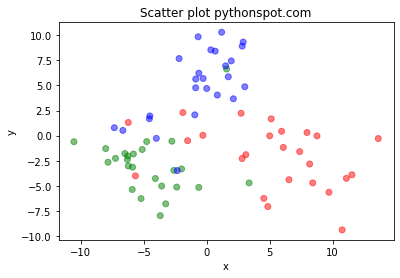

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Create data

x = principalDf['principal component 1']
y = principalDf['principal component 2']

# Plot

colors = {'technology':'red', 'world':'blue', 'sports':'green'}
plt.scatter(x, y, alpha=0.5, c = news_df['news_category'].apply(lambda x: colors[x]))
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# A Tarefa começa aqui!

# OBJETIVOS:

- Testar diferentes formas de redução de dimensão 
- Teste mais fatores além de 2 no pca
- Escolha outro método de redução de dimensionalidade e veja os resultados

- Metrifique esses resultados (calcule as distâncias entre os clusters, e a distância dentro deles)

Tentar entender como os resultados mudam em relação à dimensão e a distância atrelada a ela


In [ ]:
X, y = final_feature_matrix, news_df['news_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

PCA 3 dim

In [146]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents
             ,columns = ['principal component 1', 'principal component 2', 'principal component 3'])


[0.21701324 0.12000585 0.10239662]


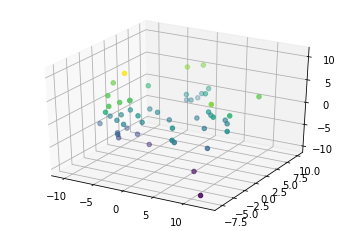

In [147]:
from mpl_toolkits import mplot3d


print(pca.explained_variance_ratio_)
# Create data

x = principalDf['principal component 1']
y = principalDf['principal component 2']
z = principalDf['principal component 3']

# Data for three-dimensional scattered points
ax = plt.axes(projection='3d')
zdata = z
xdata = x
ydata = y

ax.scatter3D(xdata, ydata, zdata, c=zdata, );


Vemos que em 3 dimensões podemos visualizar melhor a dispersão dos dados e como eles se agrupam

Nesta dimensão nota-se a presença de pontos nos pontos extremos, indicando que há features a serem exploradas

#### Lda

Método de Análise Discriminante Linear (LDA) usado para encontrar uma combinação linear de características que caracteriza ou separa classes. A combinação resultante é usada para redução de dimensionalidade antes da classificação.

Embora o PCA (não supervisionado) tente encontrar os eixos de componentes ortogonais de variância máxima em um conjunto de dados, no entanto, o objetivo do LDA (supervisionado) é encontrar o subespaço de recursos que otimiza a separabilidade de classes.

Ref. https://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Data_Compresssion_via_Dimensionality_Reduction_2_Linear_Discriminant_Analysis.php

In [150]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_train, y_train)

In [129]:
print(lda.explained_variance_ratio_)

[0.59669633 0.40330367]


[0.59669633 0.40330367]



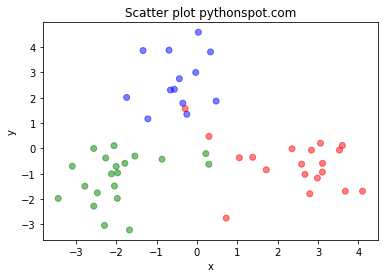

In [134]:
principalLda = pd.DataFrame(data = X_lda
             ,columns = ['principal component 1', 'principal component 2'])

print(lda.explained_variance_ratio_)
print()
# Create data
x = principalLda['principal component 1']
y = principalLda['principal component 2']

# Plot
colors = {'technology':'red', 'world':'blue', 'sports':'green'}
plt.scatter(x, y, alpha=0.5, c = y_train.apply(lambda x: colors[x]))
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [135]:
y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      sports       1.00      1.00      1.00         5
  technology       1.00      0.67      0.80         6
       world       0.86      1.00      0.92        12

    accuracy                           0.91        23
   macro avg       0.95      0.89      0.91        23
weighted avg       0.93      0.91      0.91        23



Apesar de 

## Knn

Um dos modelos mais utilizados pra clusterização de modo geral

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)


In [75]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      sports       0.71      1.00      0.83         5
  technology       1.00      0.67      0.80         6
       world       0.92      0.92      0.92        12

    accuracy                           0.87        23
   macro avg       0.88      0.86      0.85        23
weighted avg       0.89      0.87      0.87        23



## T-SNE

A incorporação de vizinhos estocásticos distribuídos em T (t-SNE) é uma técnica de redução de dimensionalidade não linear adequada para incorporar dados de alta dimensão para visualização em um espaço de baixa dimensão de duas ou três dimensões.

Ref. https://www.geeksforgeeks.org/ml-t-distributed-stochastic-neighbor-embedding-t-sne-algorithm/

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



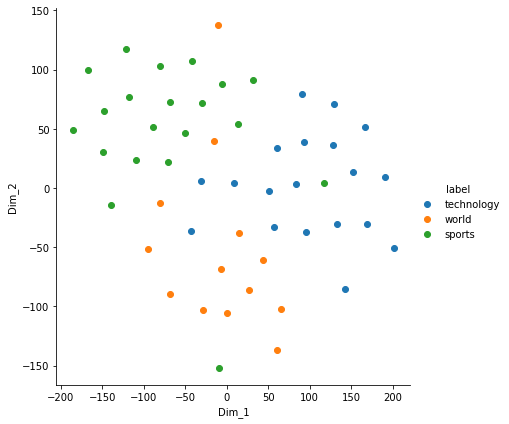

In [155]:
from sklearn.manifold import TSNE
import seaborn as sn
# TSNE
# Picking the top 1000 points as TSNE
# takes a lot of time for 15K points
data_1000 = X_train[0:1000, :]
labels_1000 = y_train[0:1000]
 
model = TSNE(n_components = 2, random_state = 0)
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations
# for the optimization = 1000
 
tsne_data = model.fit_transform(data_1000)
 
# creating a new data frame which
# help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))
 
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(
       plt.scatter, 'Dim_1', 'Dim_2').add_legend()
 
plt.show()

## Conclusões

Vamos que diferentes métodos de redução de dimensionalidade convergem para um mesmo resultado. 

A visualização em diferentes dimensões ajuda a encontrar outliers que podem estar presentes na amostra

O modelo LDA, em comparação com o modelo PCA, conseguiu aumentar a distância entre os clusters e reduzir a dstância entre as observações.

